In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq

from scipy.spatial import cKDTree

/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import liana as li

In [3]:
# slide names and x, y offsets
slides = {'A1':[3.5, 18],
          'B1':[3, 10.5],
          'C1':[1, 13.5],}

In [4]:
## load slide
slide = "C1"
exp = "V11L12-109" # V11T17-102 V11L12-109 V11T16-085
slide_path = f"data/VicariEtAl/sma/{exp}/{exp}_{slide}/output_data"
rna_path = slide_path + f"/{exp}_{slide}_RNA/outs/"

In [5]:
rna = sq.read.visium(rna_path, counts_file="filtered_feature_bc_matrix.h5")
rna.obs[['x', 'y']] = rna.obsm['spatial']

msi_raw = pd.read_csv(slide_path + f"/{exp}_{slide}_MSI/{exp}_{slide}.Visium.FMP.220826_smamsi.csv")


/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
# Only for mouse
lesion = pd.read_csv(rna_path + "/lesion.csv").set_index("Barcode")
region = pd.read_csv(rna_path +  "/region.csv").set_index("Barcode")
rna.obs = rna.obs.join(lesion)
rna.obs = rna.obs.join(region)

MSI

In [7]:
msi = msi_raw.copy().drop(['x', 'y'], axis=1)
msi = sc.AnnData(X=msi.values,
                 obs=pd.DataFrame(index=msi.index),
                 var=pd.DataFrame(index=msi.columns))

/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [8]:
# copy raw intensities
msi.layers['raw'] = msi.X

# normalize and cluster
sc.pp.normalize_total(msi, target_sum=1e4)
sc.pp.log1p(msi)
sc.pp.scale(msi)
sc.pp.pca(msi)
sc.pp.neighbors(msi, n_neighbors=10, n_pcs=20)
sc.tl.leiden(msi, resolution=0.00001)

/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation

In [9]:
# get positions; NOTE: x and y are mirrored in the msi data
positions = msi_raw[['y', 'x']].values.copy()

# estimate scaling factor
sfactor = rna.uns['spatial'][f"{exp}_{slide}"]['scalefactors']['fiducial_diameter_fullres']
sfactor

607.8085000000001

In [10]:
# inverse y
positions[:, 0] = (positions[:, 0].max() - positions[:, 0])
# offset
x_offset = slides[slide][0]
y_offset = slides[slide][1]

positions[:, 0] = positions[:, 0] + x_offset
positions[:, 1] = positions[:, 1] + y_offset

msi.obs[['array_row', 'array_col']] = positions

# scale
positions = positions * sfactor * 0.95

In [11]:
msi.uns = rna.uns.copy()

In [12]:
msi.obsm['spatial'] = positions
msi.obs[['x', 'y']] = positions

In [13]:
# remove cells that are not in the tissue
msi = msi[msi.obs['leiden'] != '1', :]

/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


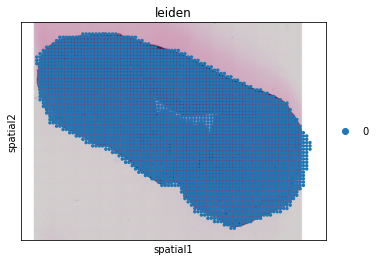

In [14]:
sc.pl.spatial(msi, color="leiden", spot_size=sfactor)

In [15]:
rna_pos = rna.obsm['spatial'].copy()
msi_pos = msi.obsm['spatial'].copy()

In [16]:
# train kdtree on rna positions
tree = cKDTree(rna_pos)

In [17]:
# find nearest neighbor for each msi spot
msi_neighbors = tree.query(msi_pos, k=1)
# calculate proximities
proximity = 1 - (msi_neighbors[0] / np.max(msi_neighbors[0]))

In [18]:
# get barcode of nearest neighbor
msi.obs['knn_barcode'] = rna.obs.iloc[msi_neighbors[1], :].index
# get proximity of nearest neighbor
msi.obs['knn_proximity'] = proximity

(array([  14.,   17.,   20.,   28.,   55.,   48.,   72.,   74.,   83.,
        2629.]),
 array([0.        , 0.09997696, 0.19995392, 0.29993088, 0.39990784,
        0.49988479, 0.59986175, 0.69983871, 0.79981567, 0.89979263,
        0.99976959]),
 <BarContainer object of 10 artists>)

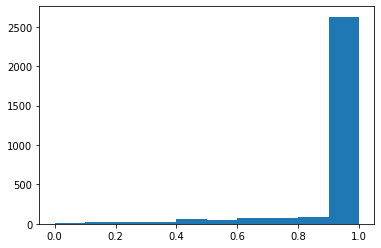

In [19]:
# histrogram of distances
from matplotlib import pyplot as plt
plt.hist(proximity, bins=10)

... storing 'knn_barcode' as categorical


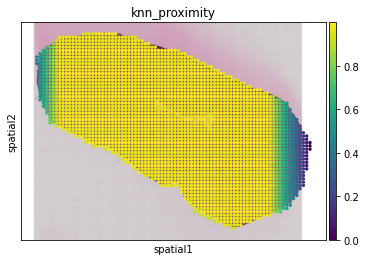

In [20]:
sc.pl.spatial(msi, color="knn_proximity", spot_size=sfactor)

In [23]:
# filter according to knn proximity
# msi = msi[msi.obs['knn_proximity'] > 0.8]

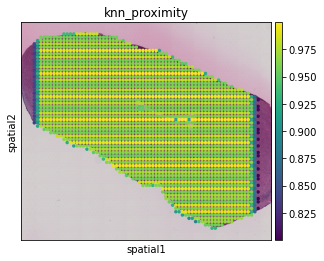

In [25]:
sc.pl.spatial(msi, color="knn_proximity", spot_size=sfactor)

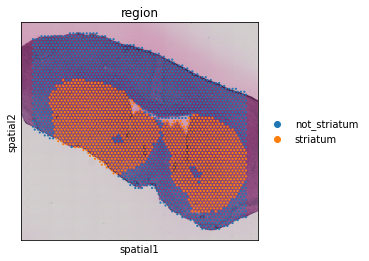

In [28]:
sc.pl.spatial(rna, color="region")

In [ ]:
import muon as mu

In [ ]:
mdata = mu.MuData({'rna':rna, 'msi':msi})

In [ ]:
sq.pl.spatial_scatter(msi, color=[# '674.2522', '674.26665', '674.26906',
                                  '674.2805', # Dopamine
                                #   '674.28592', '674.28833'
                                  ])

In [ ]:
# swap back to raw intensities
mdata.mod['msi'].X = mdata.mod['msi'].layers['raw'].copy()
del mdata.mod['msi'].layers['raw']

In [ ]:
mdata.write_h5mu(slide_path + "/sma.h5mu")